In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from collections import deque
import random
import os
import sys
import pathlib
from collections import deque
from tqdm.notebook import tqdm, trange
import datetime
from scipy import interpolate
import math

import matplotlib.ticker as mtick
import matplotlib.dates as md

from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)
    
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

/home/pierre/miniconda3/envs/exec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Optimal Strategies & Trading parameters

In [2]:
strategies  = {'imbalance' : {'name'             : 'imbalance',
                              'params'           : {'feature_name'     : 'imbalance_1',
                                                      'estimation_period': '1min',
                                                      'use_interpolator' : False,
                                                      'alpha'            : 10, 
                                                      'phi'              : 0.001, 
                                                      'kappa'            : 9e-10},
                                'contextual_params': {'feature_name'  : 'vol_50_50000'}},
               
               'trend' : {'name'             : 'imbalance',
                            'params'           : {'feature_name'     : 'LT',
                                                  'estimation_period': '1min', 
                                                  'use_interpolator' : False,
                                                  'alpha'            : 10, 
                                                  'phi'              : 0.001, 
                                                  'kappa'            : 9e-10},
                            'contextual_params': {'feature_name'  : 'vol_50_50000'}},
               
               'twap'        : {'name'             : 'TWAP',
                                'params'           : {'feature_name'     : 'imbalance_3',
                                                      'estimation_period': '1min', 
                                                      'use_interpolator' : False,
                                                      'alpha'            : 10, 
                                                      'phi'              : 0.001, 
                                                      'kappa'            : 9e-10},
                                'contextual_params': {'feature_name'  : 'vol_50_50000'}}}


strategies  = {'imbalance' : {'name'             : 'imbalance',
                              'params'           : {'feature_name'     : 'imbalance_1',
                                                      'estimation_period': '1min',
                                                      'use_interpolator' : False,
                                                      'alpha'            : 10, 
                                                      'phi'              : 0.001, 
                                                      'kappa'            : 9e-10},
                                'contextual_params': {'feature_name'  : 'vol_50_50000'}},
               
               'trend' : {'name'             : 'imbalance',
                            'params'           : {'feature_name'     : 'LT',
                                                  'estimation_period': '1min', 
                                                  'use_interpolator' : False,
                                                  'alpha'            : 10, 
                                                  'phi'              : 0.001, 
                                                  'kappa'            : 9e-10},
                            'contextual_params': {'feature_name'  : 'vol_50_50000'}}}


strategies  = {'imbalance' : {'name'             : 'imbalance',
                              'params'           : {'feature_name'     : 'imbalance_1',
                                                      'estimation_period': '1min',
                                                      'use_interpolator' : False,
                                                      'alpha'            : 10, 
                                                      'phi'              : 0.001, 
                                                      'kappa'            : 9e-10},
                                'contextual_params': {'feature_name'  : 'vol_50_50000'}}}

# GP bandits

In [3]:
from AOE.gp_bandit import gp_bandit_finance

In [4]:
# Parameters bandit
size_buffer   = 1000
size_window   = 16
size_subwindow   = 8
training_iter = 30# Parameters bandit
size_buffer   = 1000
size_window   = 16
size_subwindow   = 8
training_iter = 30
bandit_params = 0.1
type_1_error = 0.05
likelihood    = gpytorch.likelihoods.GaussianLikelihood()
bandit_algo   = 'TS'
threshold = 2*type_1_error
bandit = gp_bandit_finance(strategies, bandit_algo=bandit_algo, bandit_params=bandit_params, training_iter=training_iter, size_buffer=size_buffer, size_window=size_window, size_subwindow=size_subwindow, type_1_error=type_1_error, threshold = threshold)

In [5]:
%matplotlib inline

seed = 7
torch.manual_seed(seed)
np.random.seed(seed)

In [6]:
list(bandit.strat_gp_dict["imbalance"].model.covar_module.parameters())

[Parameter containing:
 tensor(0., requires_grad=True),
 Parameter containing:
 tensor([[0.]], requires_grad=True)]

# Trading simulation

/home/pierre/miniconda3/envs/exec/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


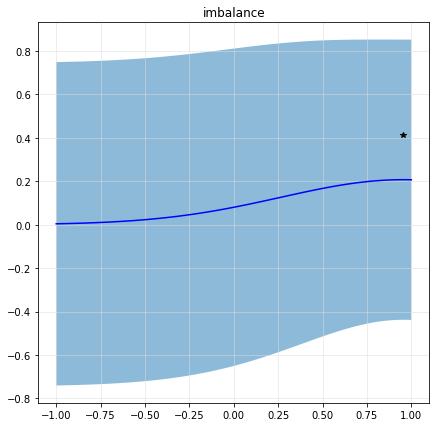

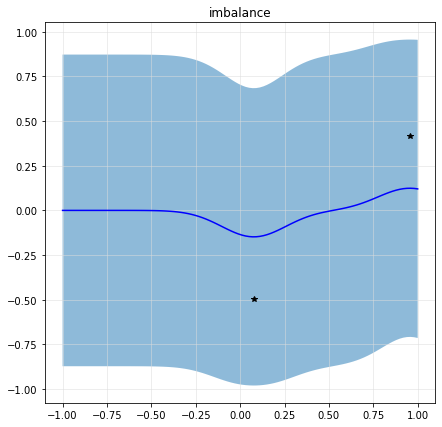

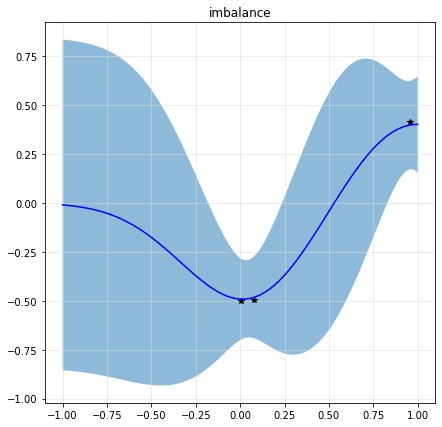

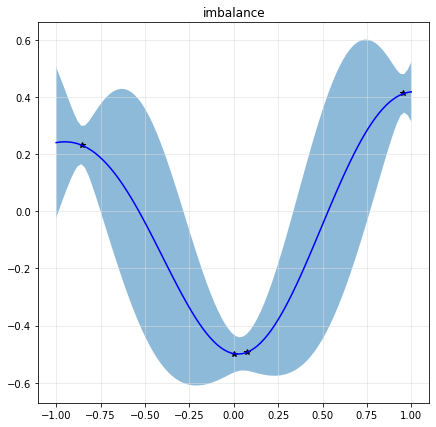

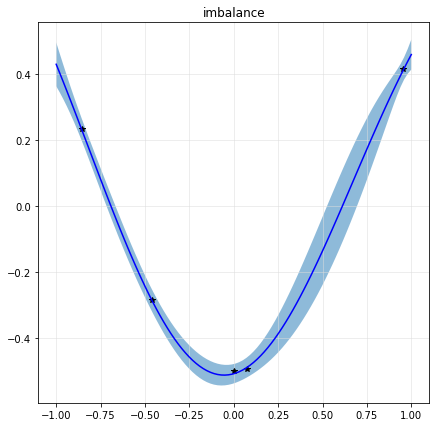

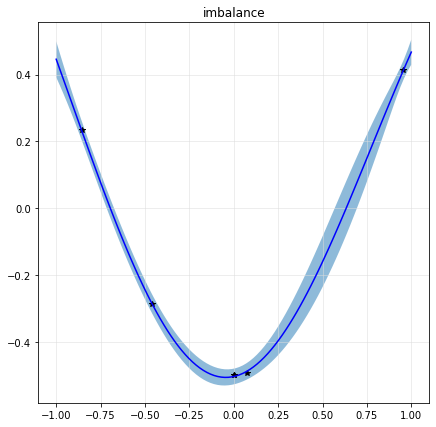

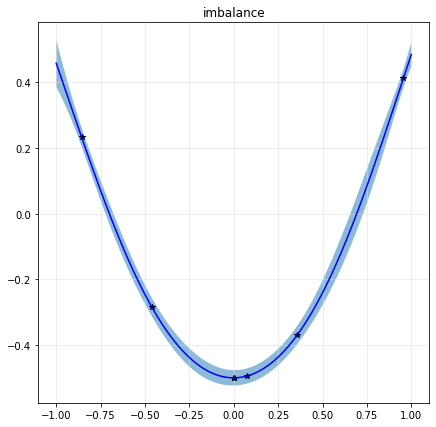

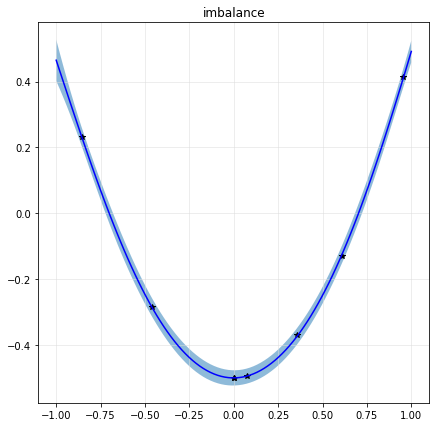

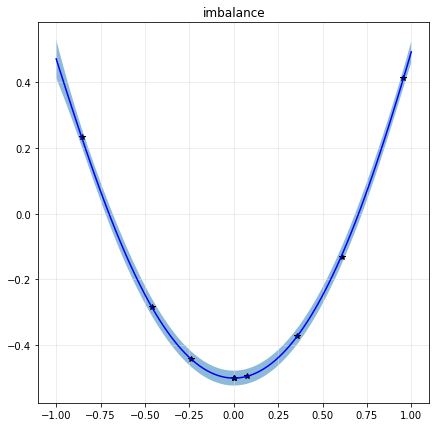

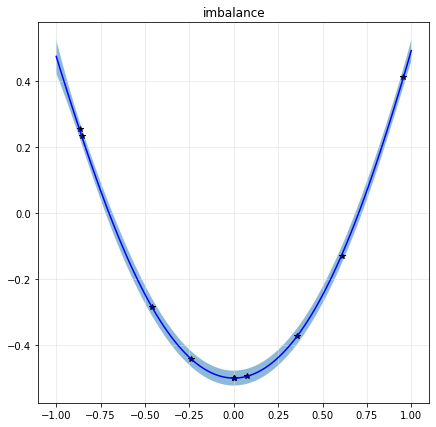

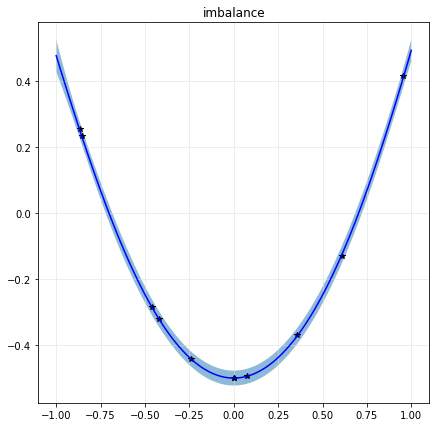

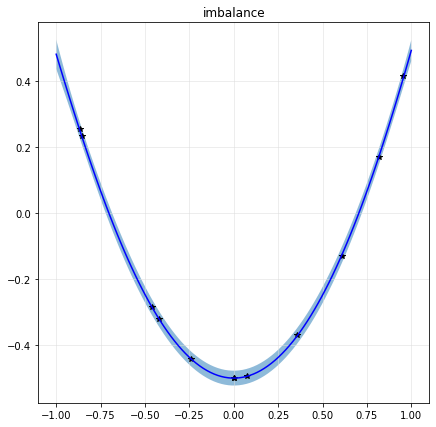

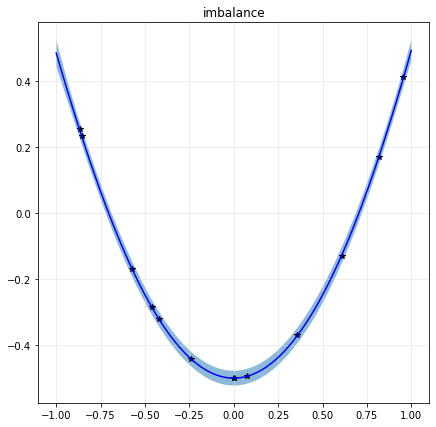

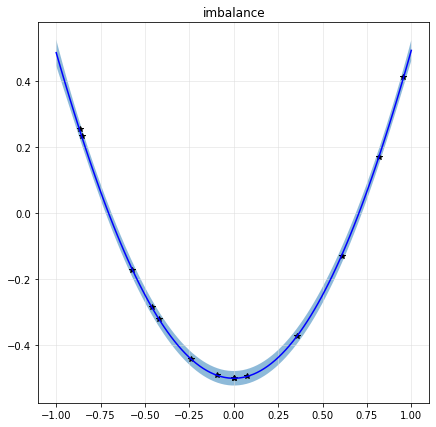

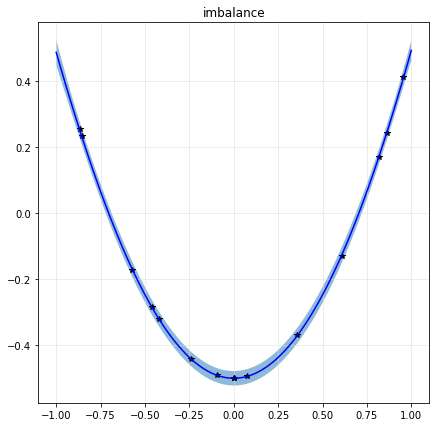

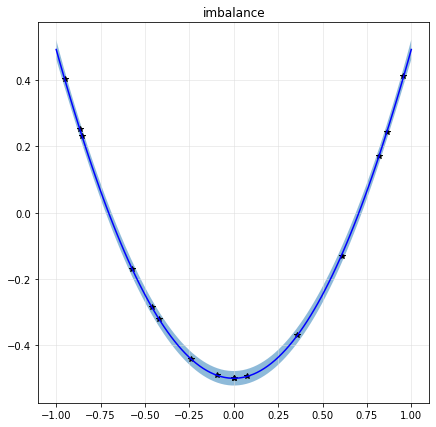

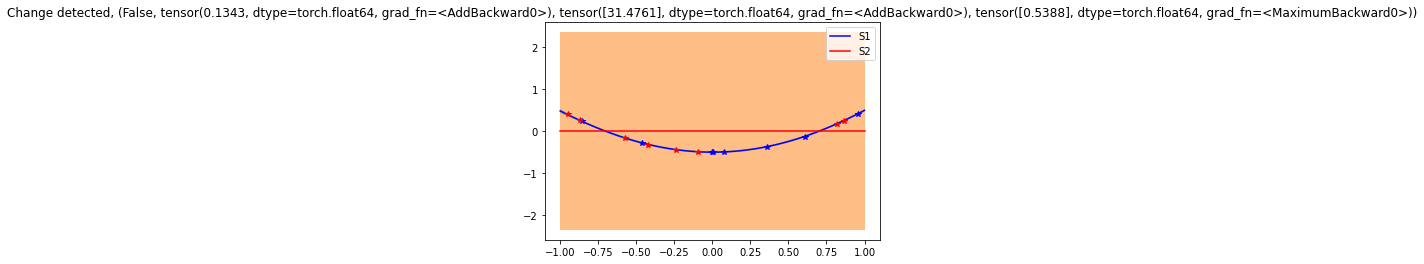

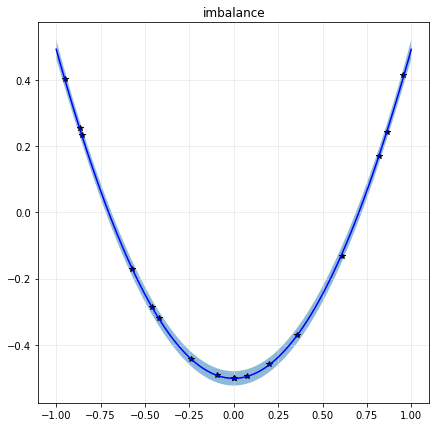

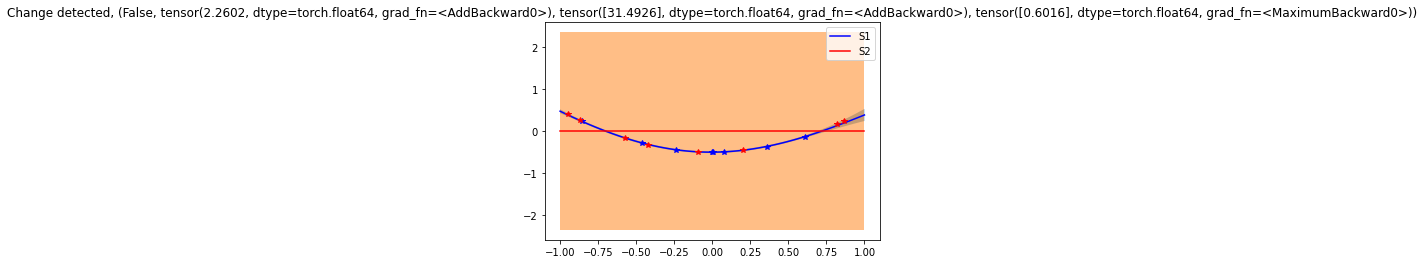

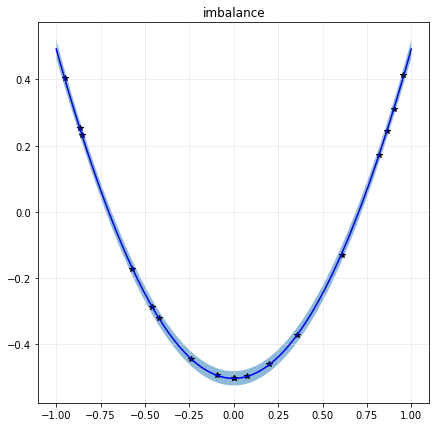

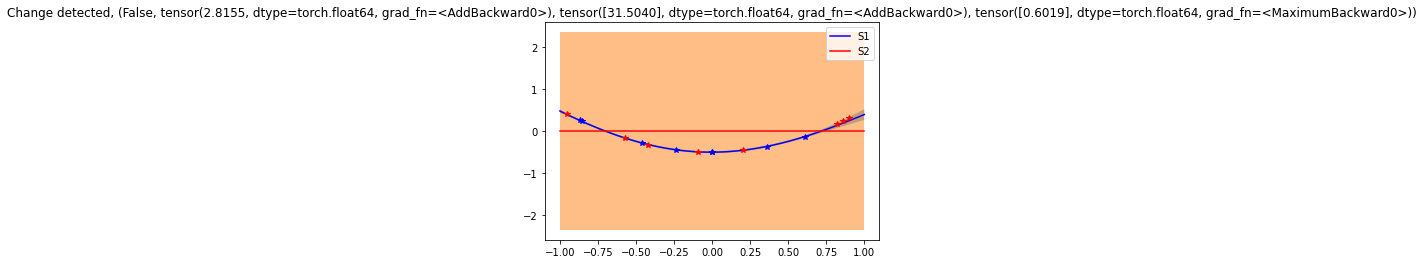

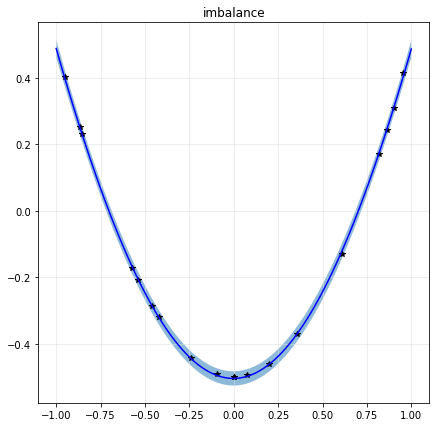

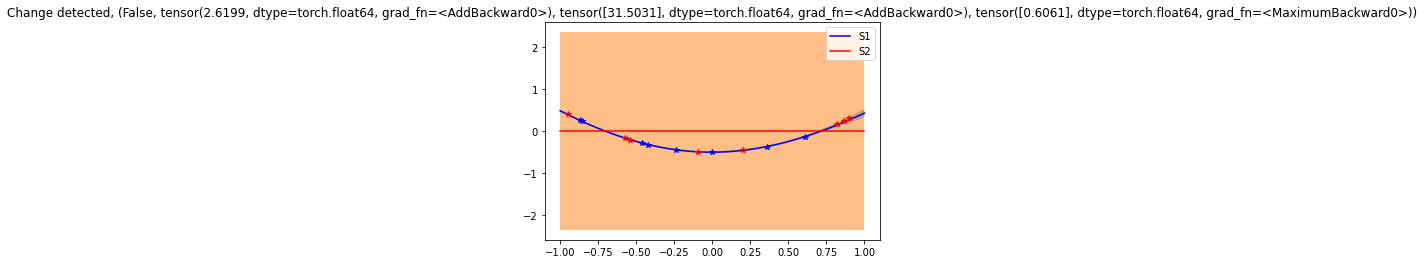

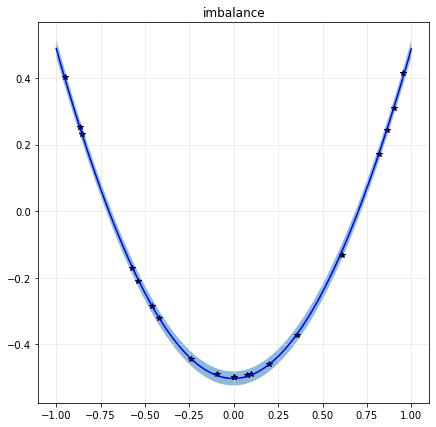

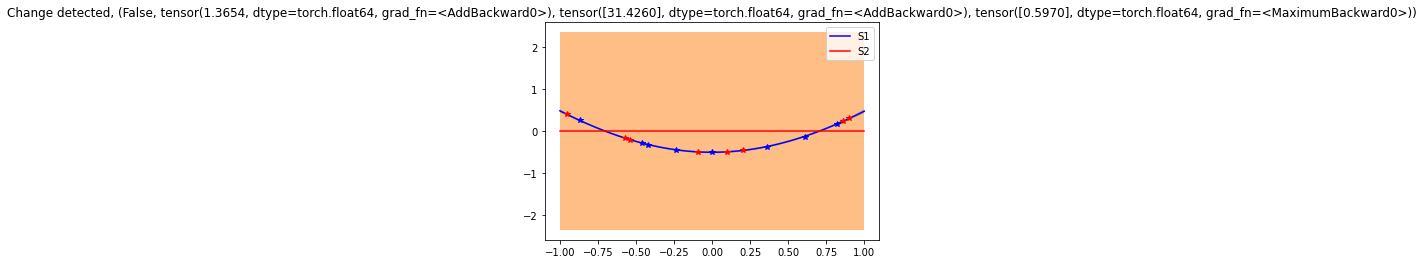

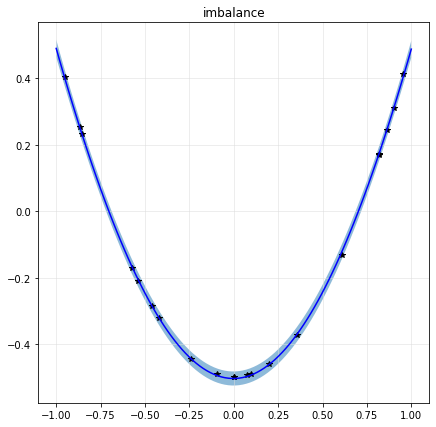

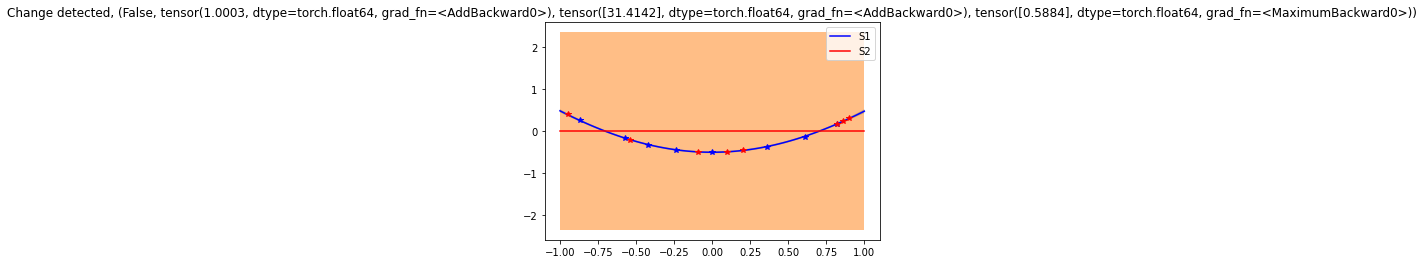

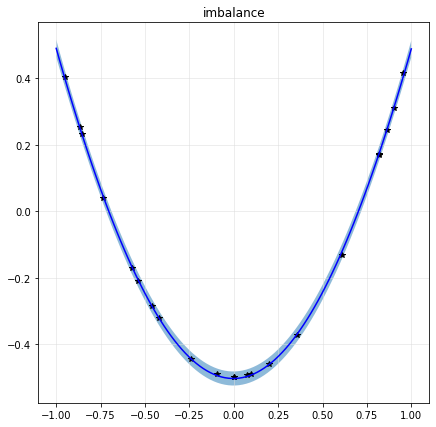

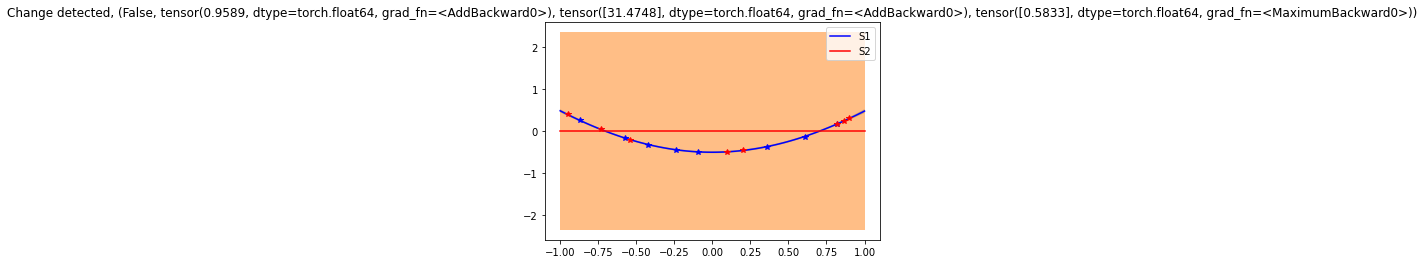

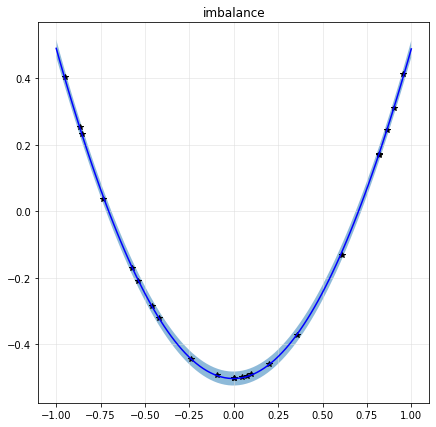

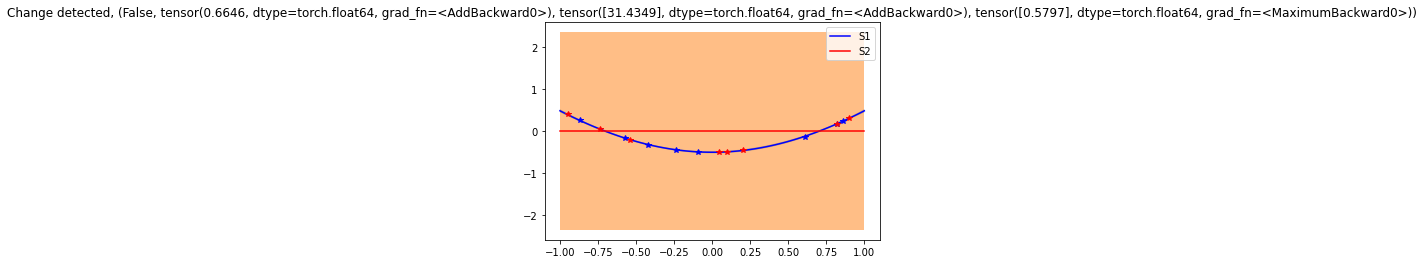

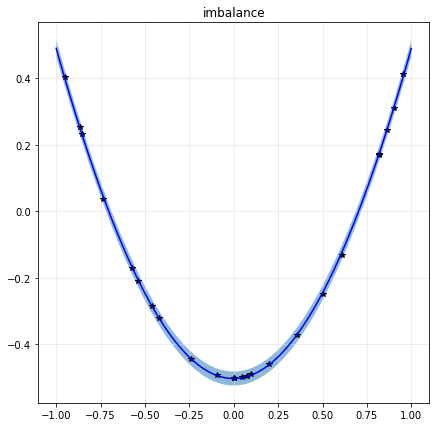

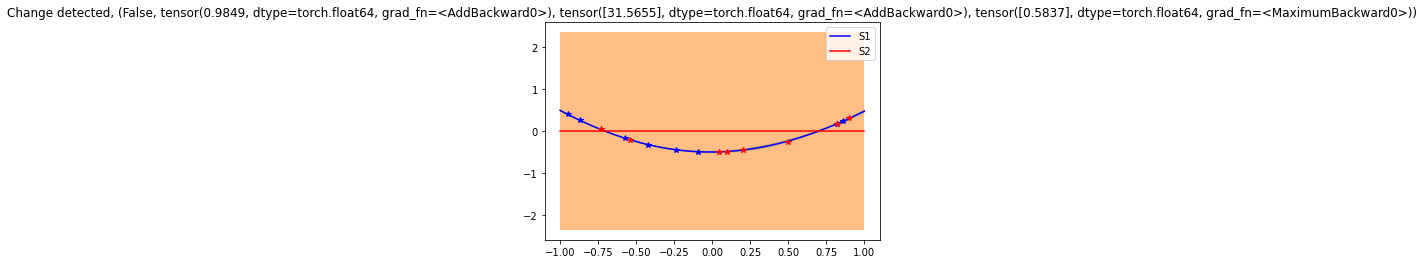

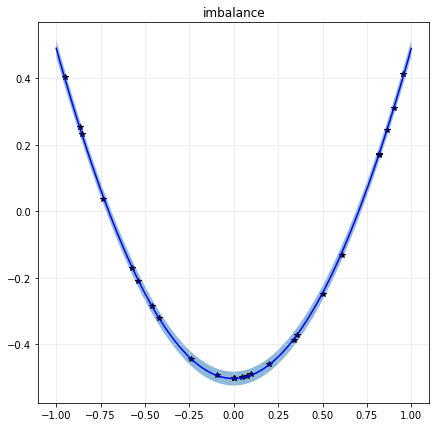

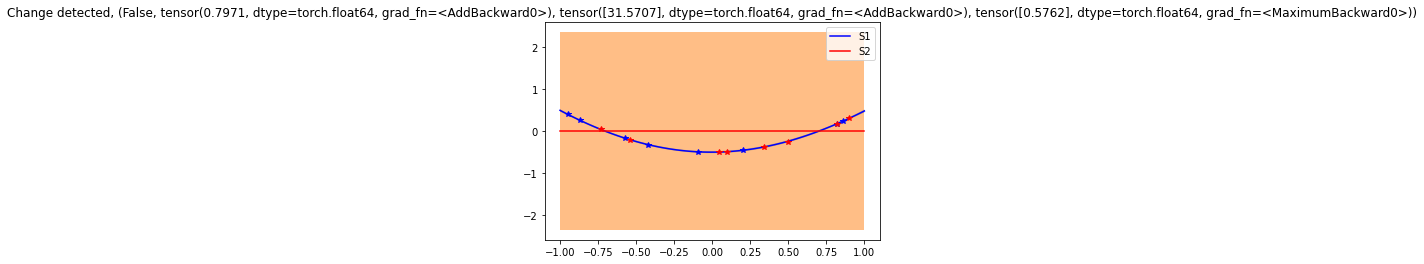

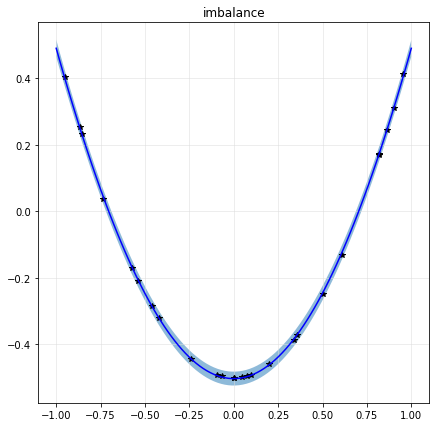

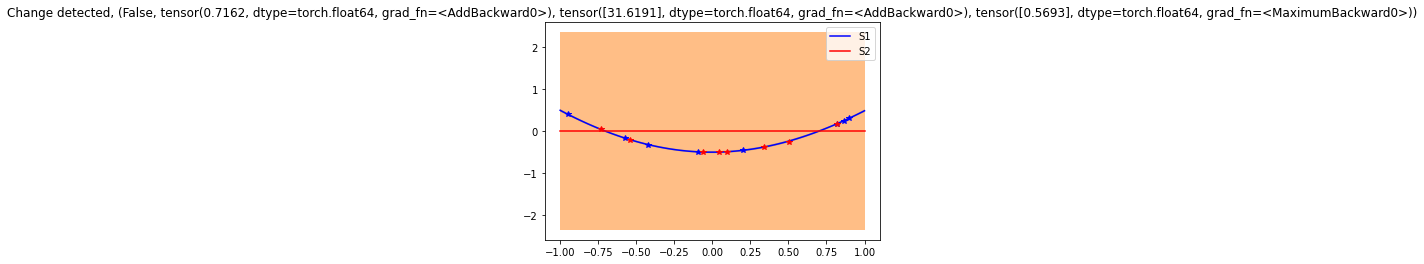

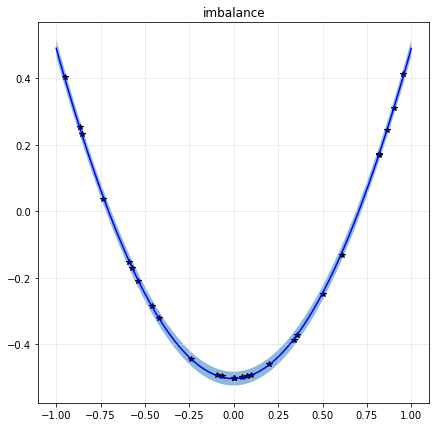

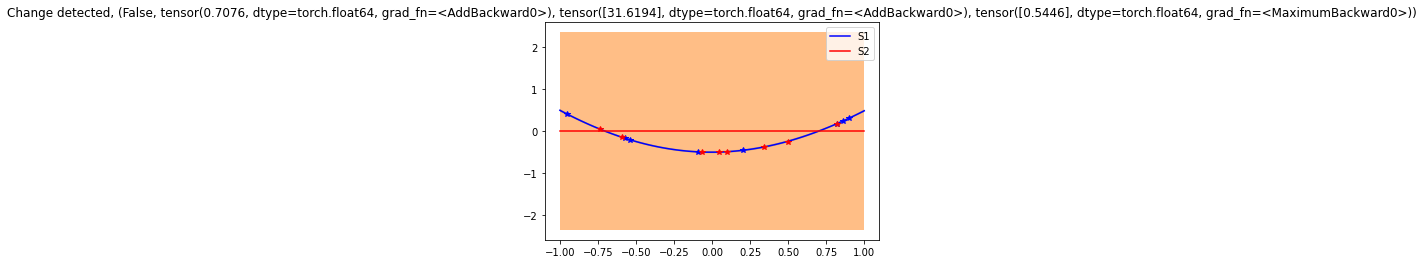

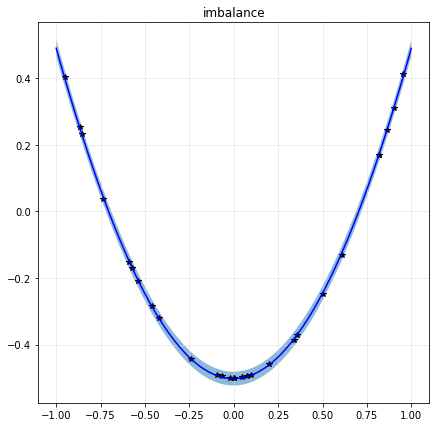

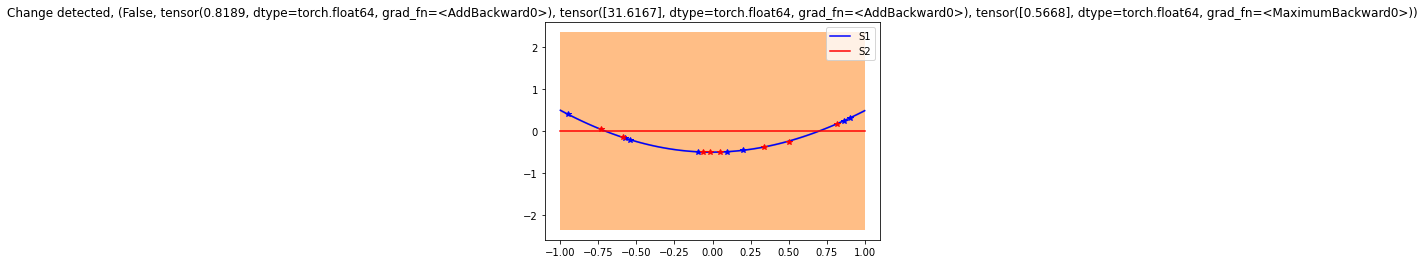

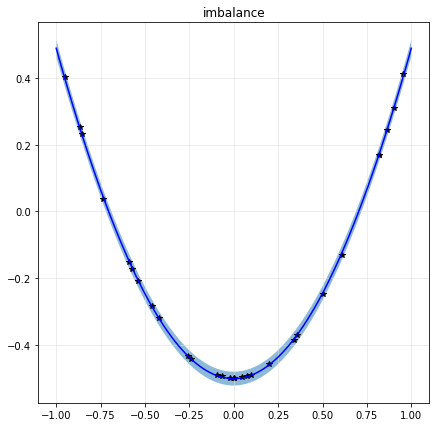

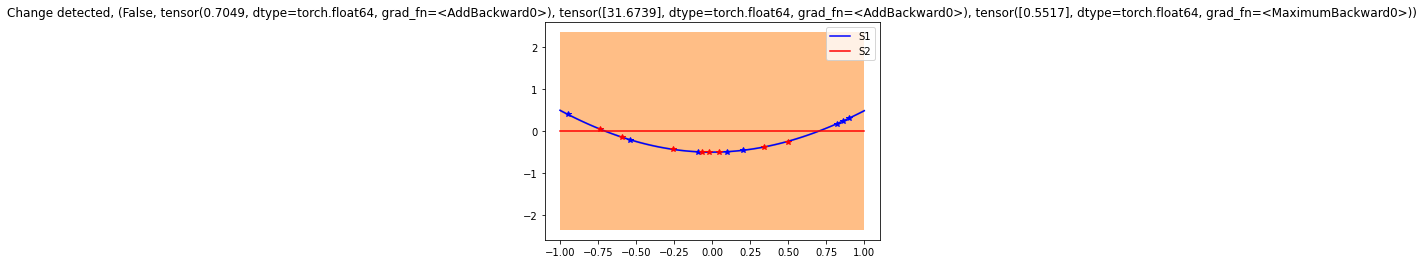

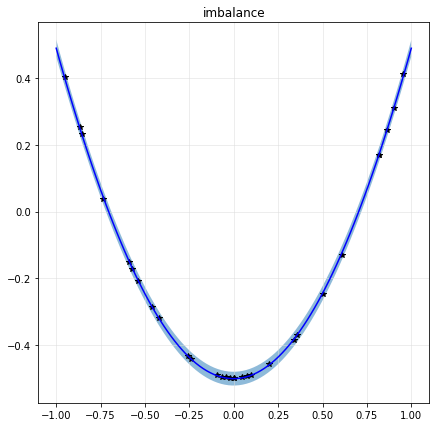

---------------Change of regime!!!! ------------------


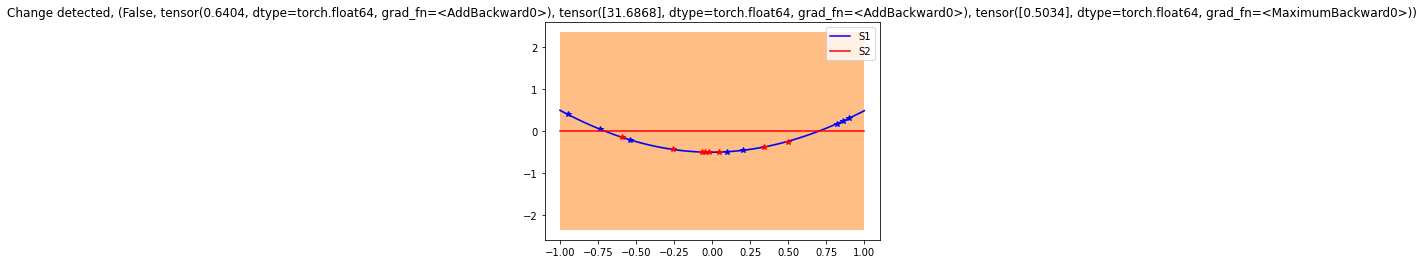

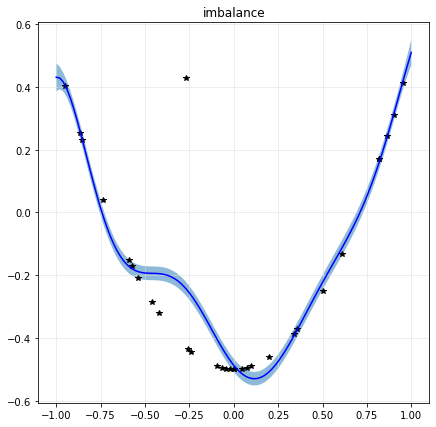

Change detected
Regime change detected for strategy imbalance, corresponding arm reinitialized


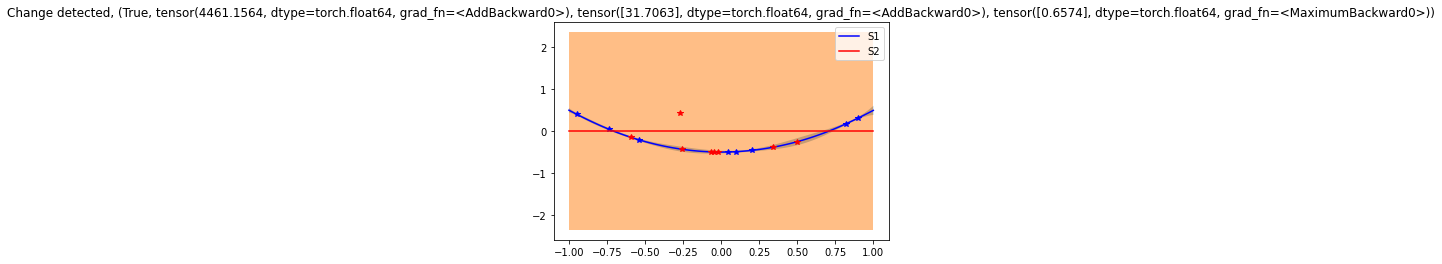

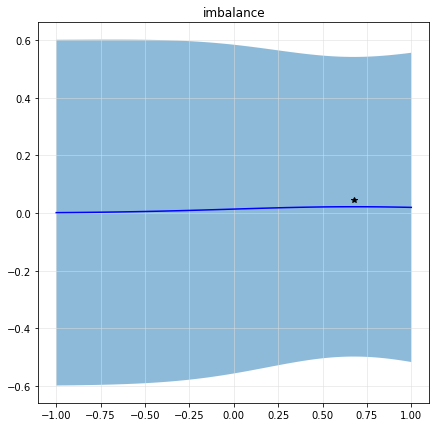

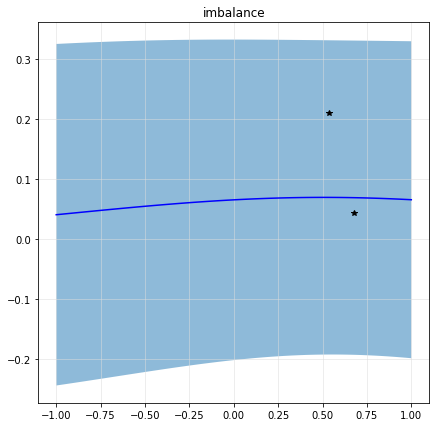

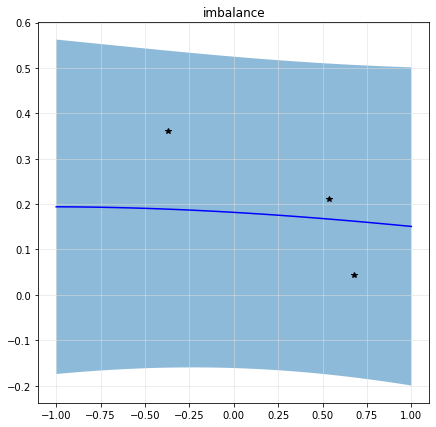

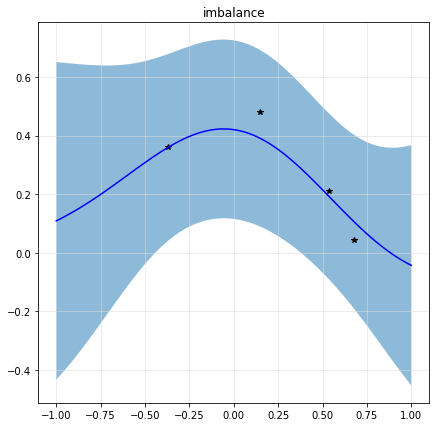

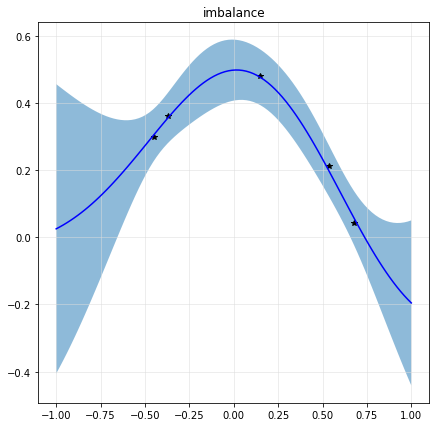

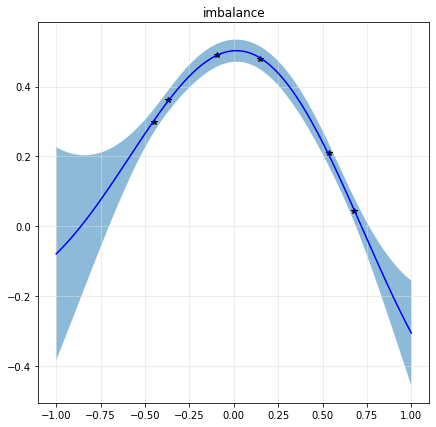

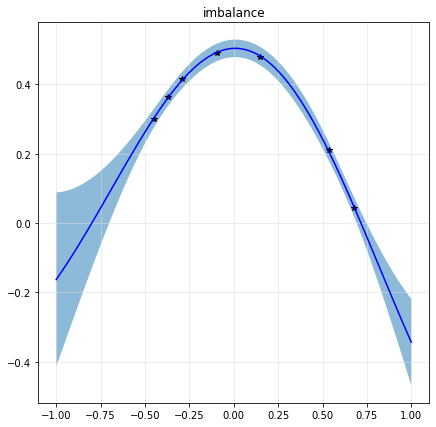

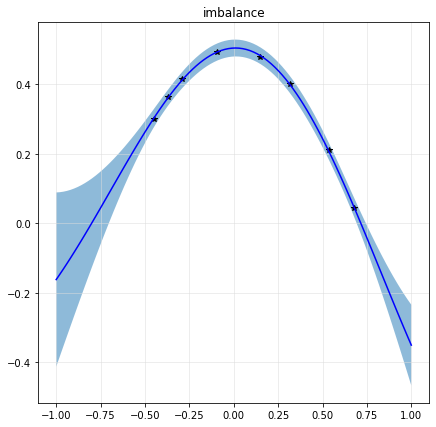

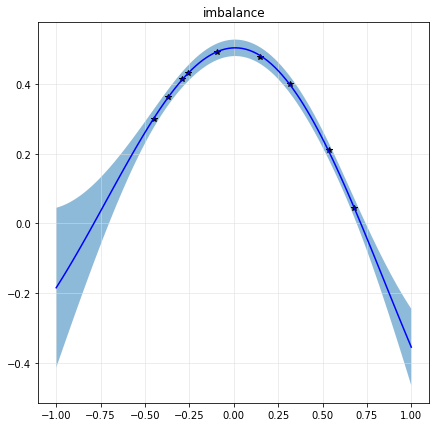

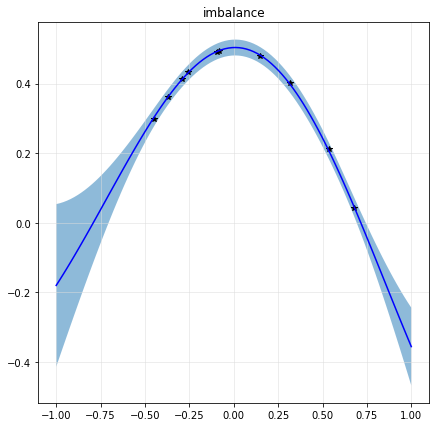

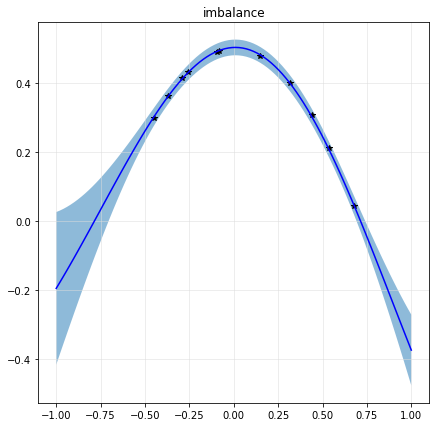

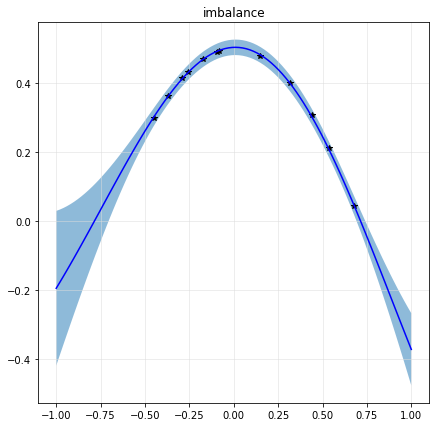

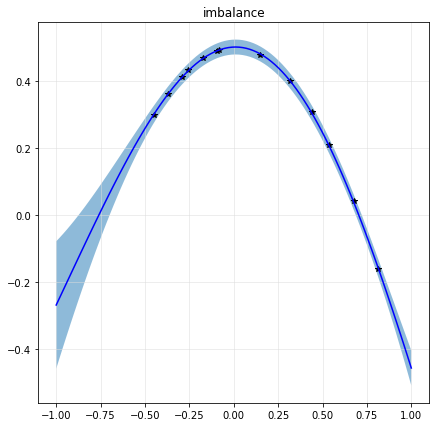

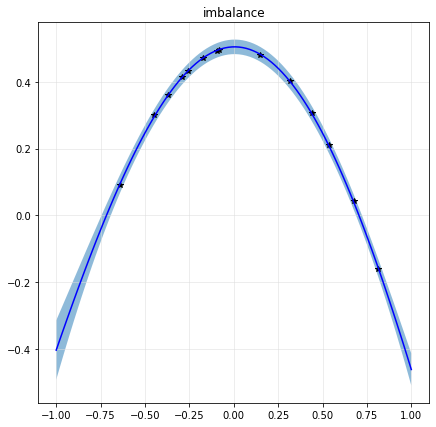

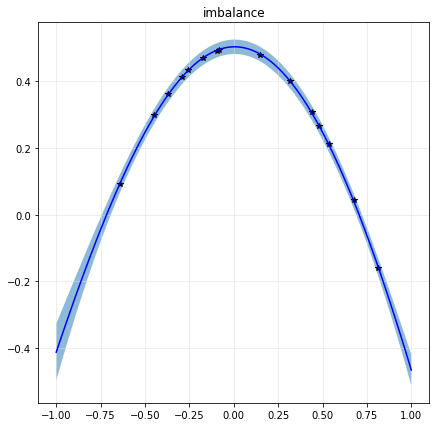

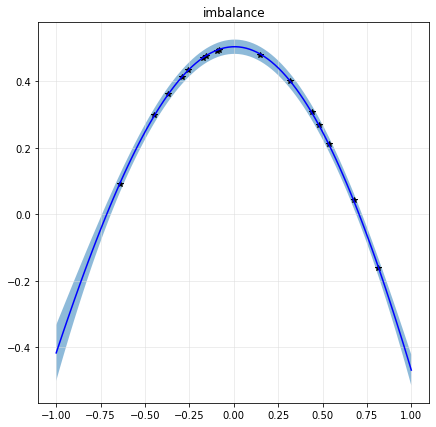

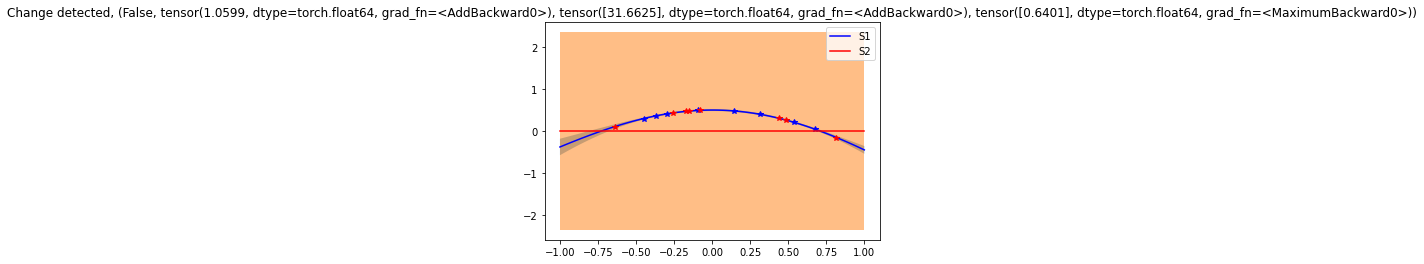

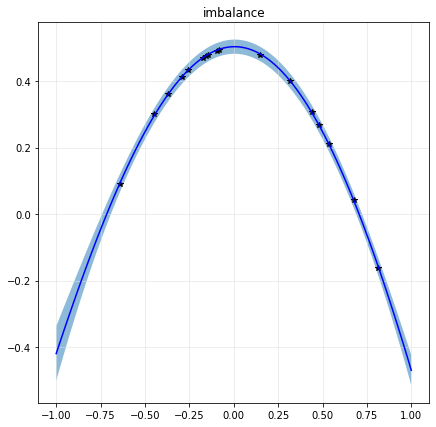

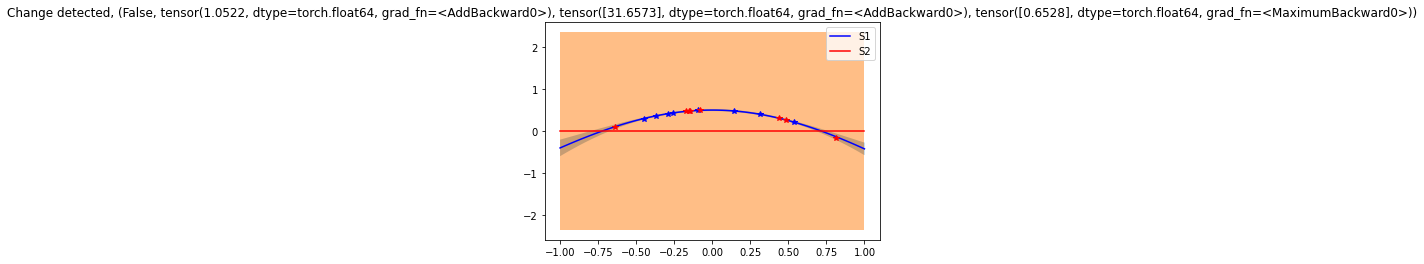

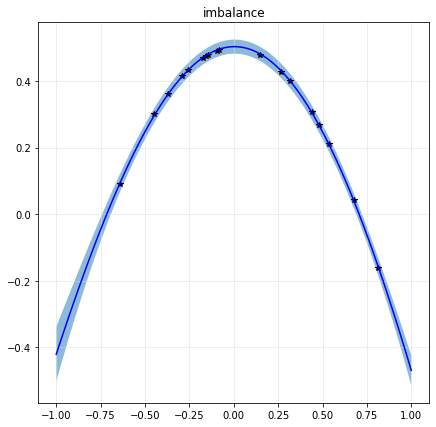

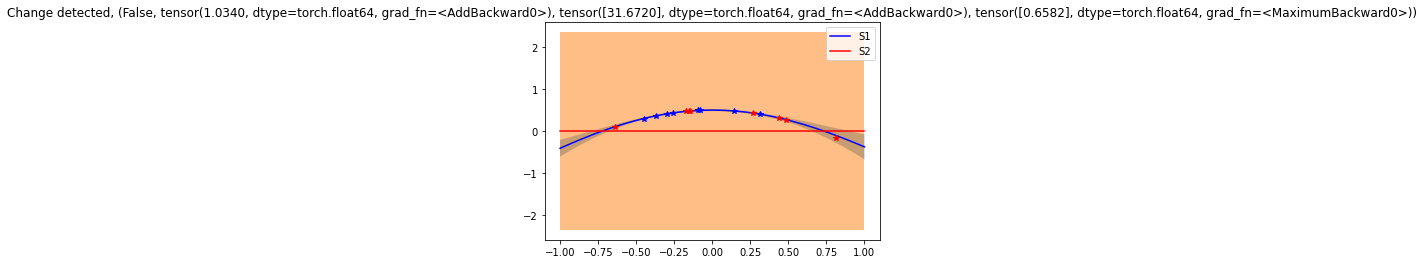

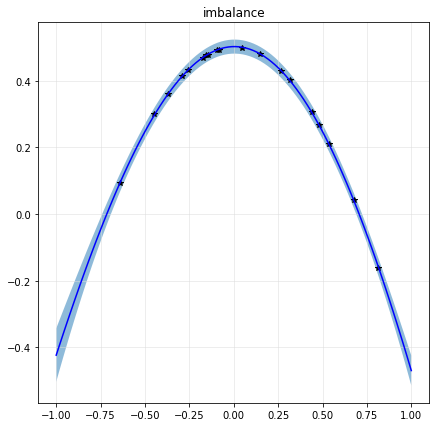

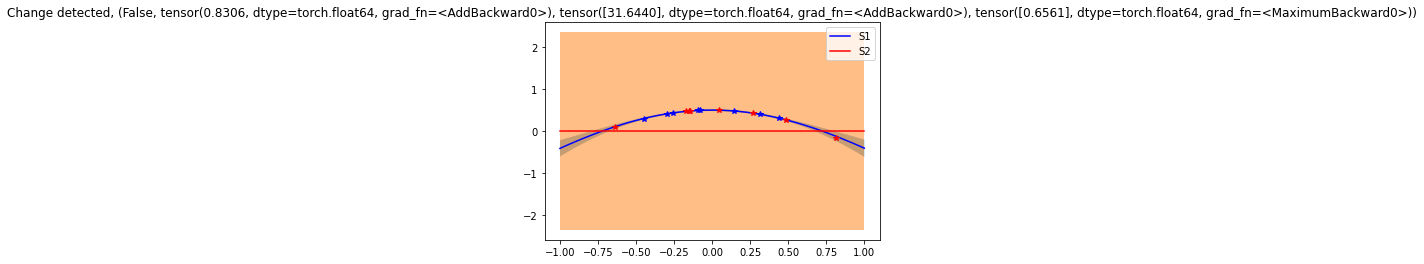

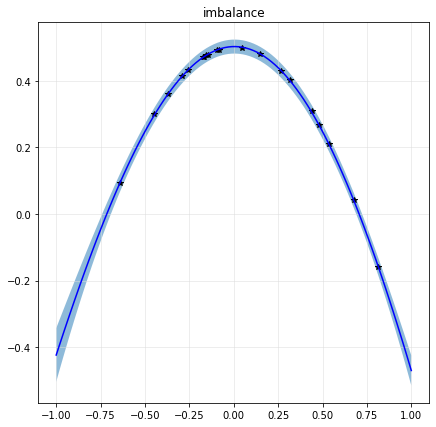

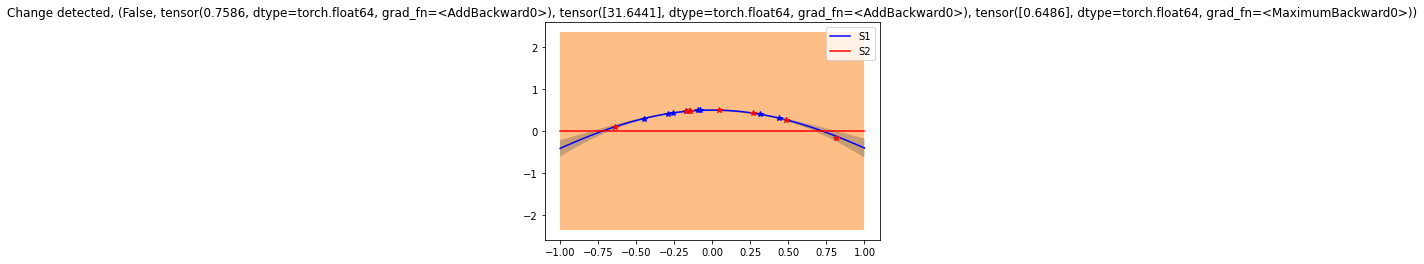

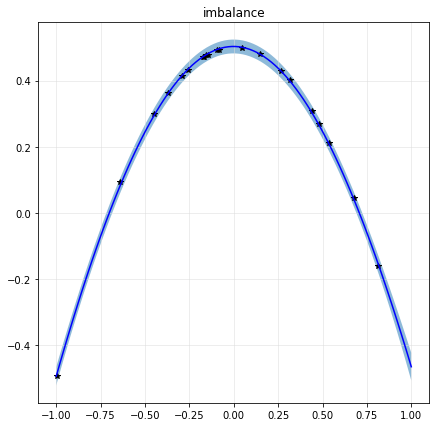

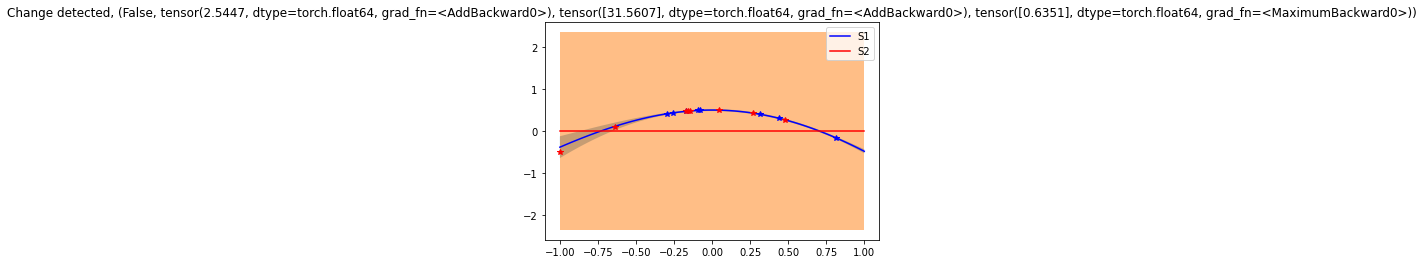

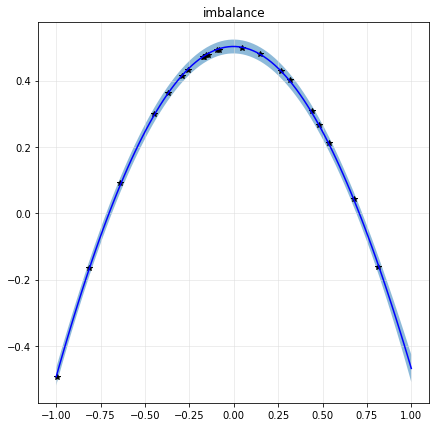

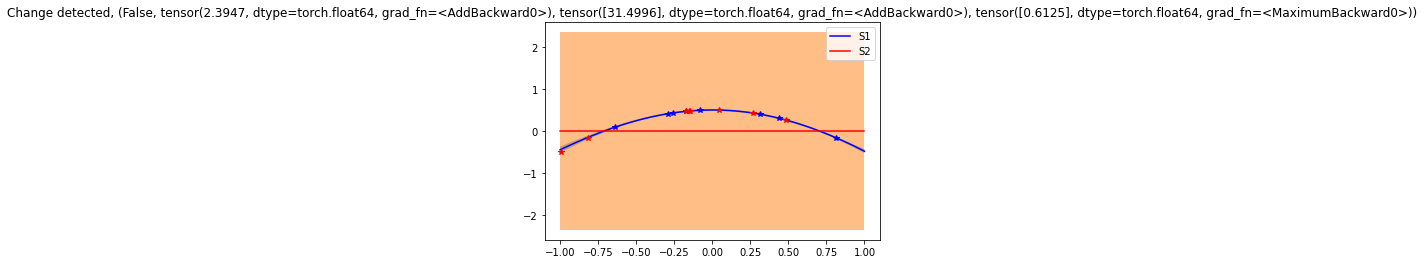

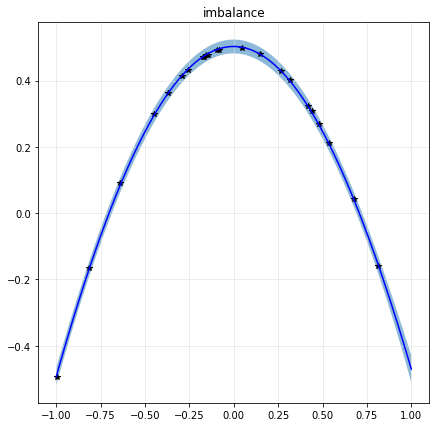

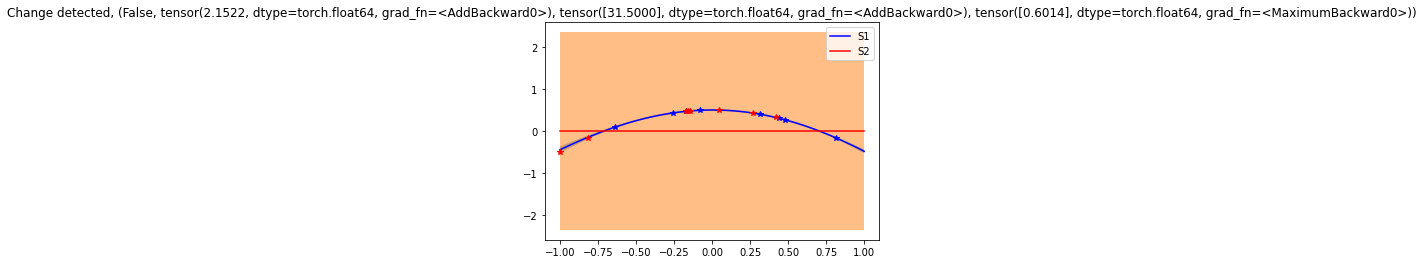

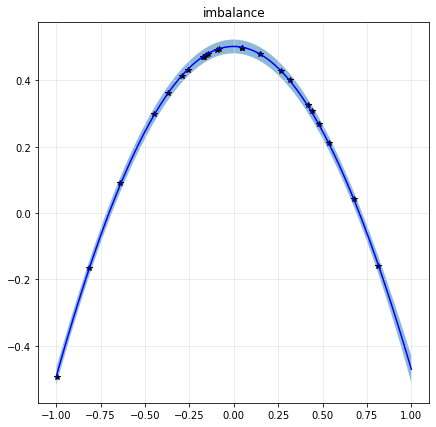

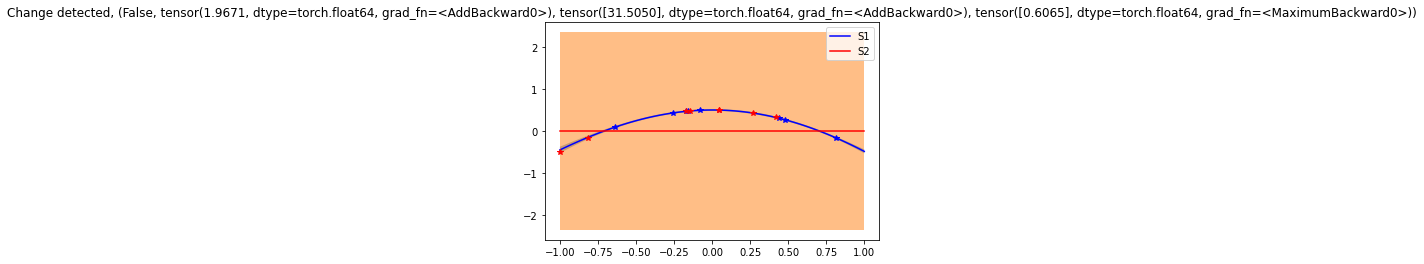

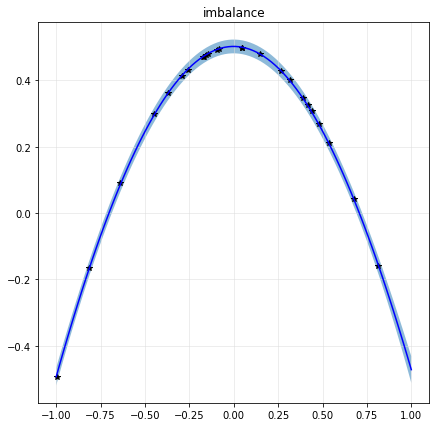

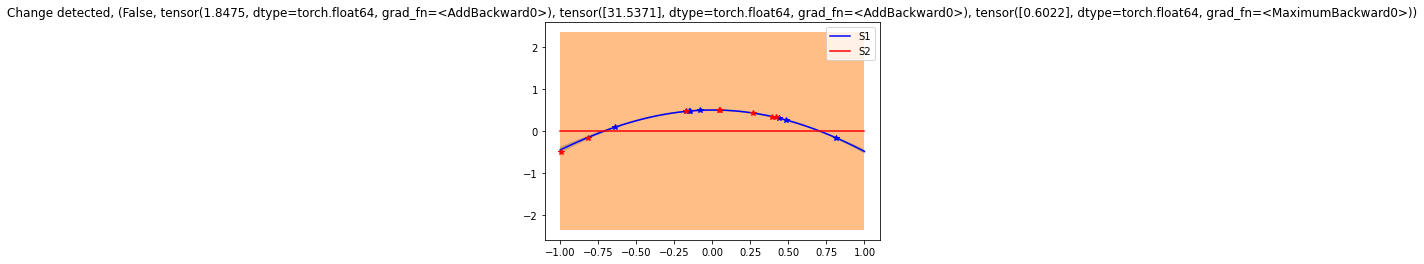

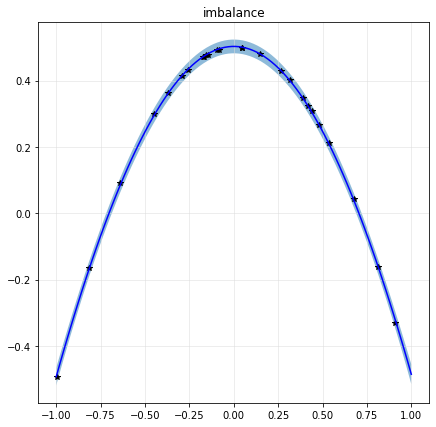

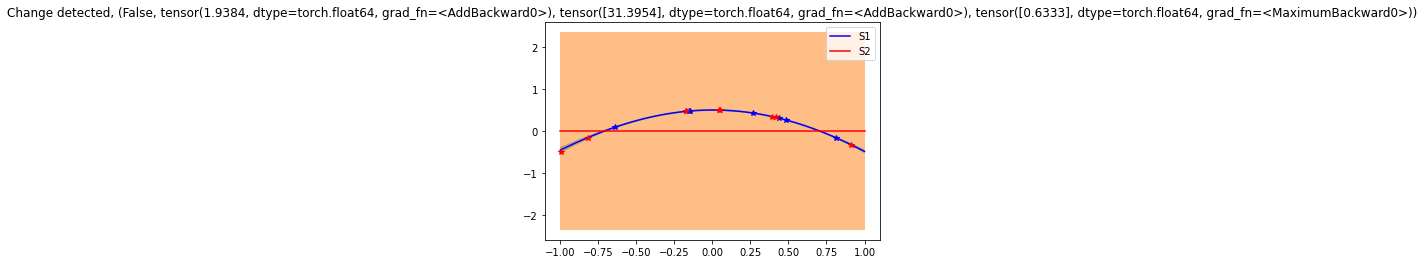

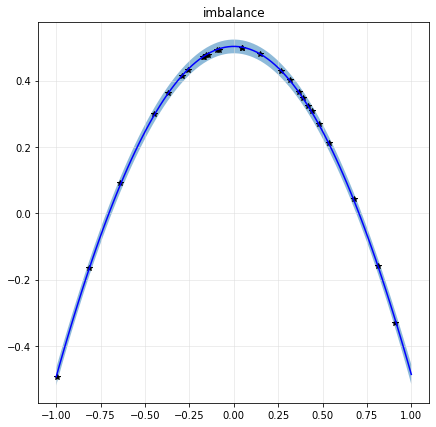

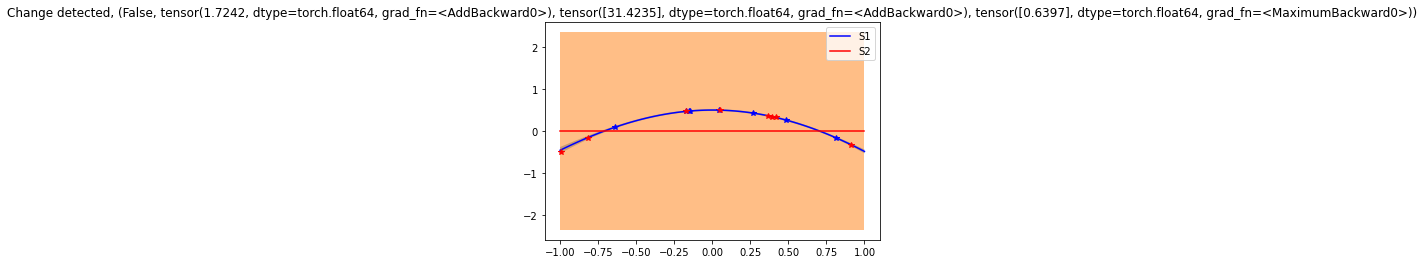

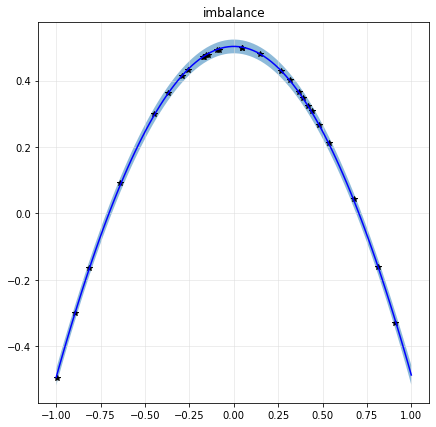

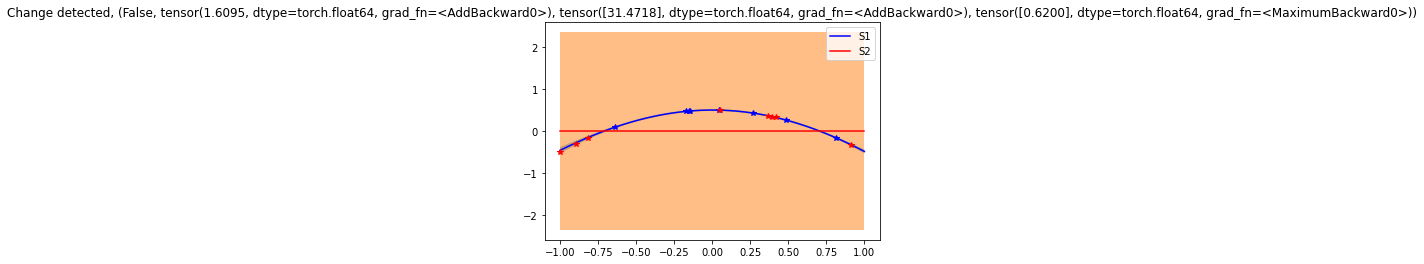

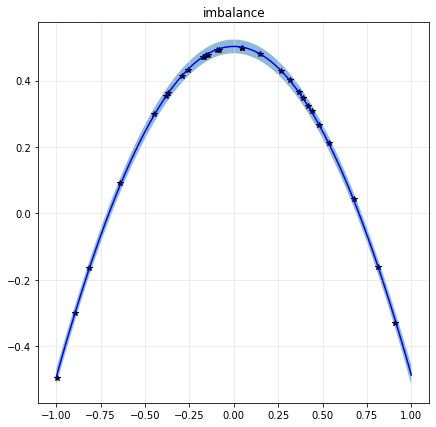

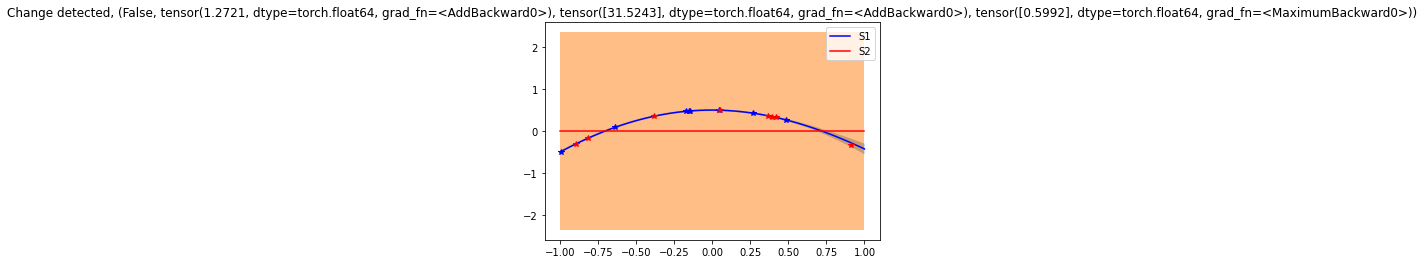

In [7]:

reward_1 = lambda x: x**2 - 0.5
reward_2 = lambda x: -x**2 + 0.5
d = {'vol_50_50000': np.random.normal()}

distances_pre = []
distances_post = []
for i in range(30):

    d['vol_50_50000'] = 2*np.random.random() - 1
    feature_values = pd.Series(data=d, index=['vol_50_50000'])
    best_strategy_bandit  = bandit.select_best_strategy(feature_values)
    reward = reward_1(d['vol_50_50000'])
    bandit.update_data(feature_values, best_strategy_bandit, reward, retrain_hyperparameters = True)
    
    #bandit.plot_strategies(["imbalance"], plot_path = f"./strat_{i}.png")
    
    bandit.plot_strategies(["imbalance"])
    result = bandit.posterior_S2("imbalance")
    
    if result != False:
        train_x_1, train_y_1, posterior_mean_1, lower1, upper1 = result
        train_x_2, train_y_2, posterior_mean_2, lower2, upper2 = bandit.prior_S2("imbalance")
        
        test_x = torch.linspace(-1, 1, 100).double()
        f, ax = plt.subplots(1, 1)

        ax.plot(test_x.numpy(), posterior_mean_1.numpy(), 'b', label="S1")
        ax.plot(train_x_1.numpy(), train_y_1.numpy(), 'b*')
        
        ax.plot(test_x.numpy(), posterior_mean_2.numpy(), 'r', label="S2")
        ax.plot(train_x_2.numpy(), train_y_2.numpy(), 'r*')

        change_point = bandit.change_point("imbalance")
        
        if change_point[0]:
            print("Change detected")
            bandit.reinitialize_arm()
        
        ax.set_title(f"Change detected, {change_point}")
        
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower1.detach().numpy(), upper1.detach().numpy(), alpha=0.5)
        ax.fill_between(test_x.numpy(), lower2.detach().numpy(), upper2.detach().numpy(), alpha=0.5)
        
        ax.legend()
        #f.savefig(f'./test_image_{i}.png', dpi = 150)
    
    


print("---------------Change of regime!!!! ------------------")
for i in range(30):
    d['vol_50_50000'] = 2*np.random.random() - 1
    feature_values = pd.Series(data=d, index=['vol_50_50000'])
    best_strategy_bandit  = bandit.select_best_strategy(feature_values)
    
    reward = reward_2(d['vol_50_50000'])
    
    bandit.update_data(feature_values, best_strategy_bandit, reward, retrain_hyperparameters = True)
    
    bandit.plot_strategies(["imbalance"])
    result = bandit.posterior_S2("imbalance")
    
    if result != False:
        train_x_1, train_y_1, posterior_mean_1, lower1, upper1 = result
        train_x_2, train_y_2, posterior_mean_2, lower2, upper2 = bandit.prior_S2("imbalance")
        
        test_x = torch.linspace(-1, 1, 100).double()
        f, ax = plt.subplots(1, 1)

        ax.plot(test_x.numpy(), posterior_mean_1.numpy(), 'b', label="S1")
        ax.plot(train_x_1.numpy(), train_y_1.numpy(), 'b*')
        
        ax.plot(test_x.numpy(), posterior_mean_2.numpy(), 'r', label="S2")
        ax.plot(train_x_2.numpy(), train_y_2.numpy(), 'r*')
        

        change_point = bandit.change_point("imbalance")

        if change_point[0]:
            print("Change detected")
            bandit.reinitialize_arm()
        
        ax.set_title(f"Change detected, {change_point}")
        
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower1.detach().numpy(), upper1.detach().numpy(), alpha=0.5)
        ax.fill_between(test_x.numpy(), lower2.detach().numpy(), upper2.detach().numpy(), alpha=0.5)
        
        ax.legend()
        #f.savefig(f'./test_image_{i}.png', dpi = 150)

    #bandit.change_point(strat, n_test = 100, lv = -1, uv = 1)
        
#plt.plot(distances)

In [8]:
upper2

tensor([2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549,
        2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549,
        2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549,
        2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549,
        2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549,
        2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549,
        2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549,
        2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549,
        2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549,
        2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549,
        2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549, 2.3549,
        2.3549], dtype=torch.float64)

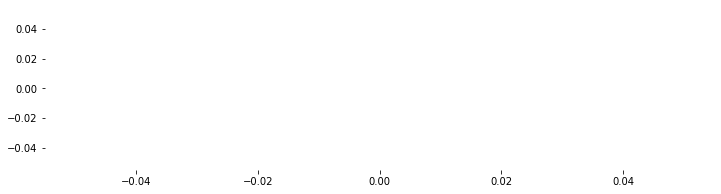

In [9]:
plt.figure(figsize=(12, 3))
plt.box(False)
plt.plot(distances_pre + distances_post)
plt.savefig("test_value.png", dpi = 600)

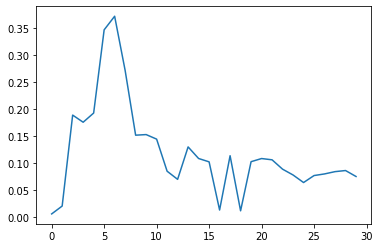

In [14]:
plt.plot(distances_post)

In [10]:
len(distances_pre)

30

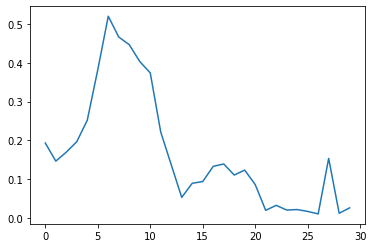

In [11]:
plt.plot(distances_post)

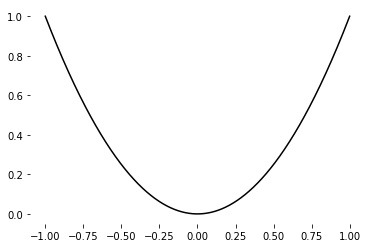

In [53]:
reward_1 = lambda x: x**2
x = np.linspace(-1,1,1000)
y = reward_1(x)
plt.box(False)
plt.plot(x, y, 'k')
plt.savefig("first_function.png", dpi = 600)

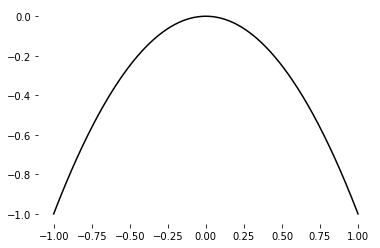

In [54]:
reward_1 = lambda x: -x**2
x = np.linspace(-1,1,1000)
y = reward_1(x)
plt.box(False)
plt.plot(x, y, 'k')
plt.savefig("second_function.png", dpi = 600)